In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [ ]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 0.5          # rate Is -> Q, fast testing for the infected 



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])
A0  = np.array([20, 20])
Ia0 = np.array([10, 10])     
Is0 = np.array([10, 10])     
Q0  = np.array([10, 10])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAIRQ_sto_traj.npy', data_array)

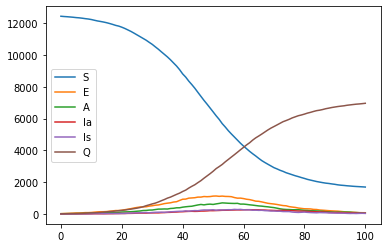

In [ ]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
plt.plot(data_array[:, 5*M], label='Q')

plt.legend()
plt.show()

# Infer parameters based on part of the trajectory

In [ ]:
# load the data and rescale to intensive variables 
Tf_inference = 40 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number internal integration steps taken



# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, False, False, True, True,True,True,True]), M)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

In [ ]:
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm, can use as a lower bound for parameters 

alpha_g = 0.2
alpha_bounds = (0.1, 0.5) # large uncertainty on the fraction of asymptomatic people 
# the upper bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1) # large uncertainty on beta (e.g. during a lockdown, beta can be very low)

gIa_g = 0.2
gIa_bounds = (eps, 0.5) # large uncertainty on how quickly asymptomatic people recover 

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) # tight bounds on gIs (can come from clinical data)

gE_g = 0.22
gE_bounds = (0.15, 0.25) # tight bounds on the exit rate from the exposed class 

gA_g = 0.3 
gA_bounds = (0.25, 0.35) # tight bounds on the exit rate from the activated class 

fsa_g = 0.8 # assume we know this precisely 


# guesses for the unknown initial conditions 
E0_g = (E0+5)/N 
bounds_for_E = [(1/N, 100/N)]*M #large uncertainty 
A0_g = (A0+5)/N 
bounds_for_A = [(1/N, 100/N)]*M #large uncertainty 
Ia0_g = Ia0/N
bounds_for_Ia = [(1/N, 100/N)]*M #large uncertainty 
S0_g = (S0-10)/N
bounds_for_S = [(fi[i]-320/N-Q0[i]/N, fi[i]-0.2/N) for i in range(M)] # consistent with other guesses 

# as a result of the van kampen system size expansion, Is0 does not have to be the same as the true value
Is0_g = Is0/N 
bounds_for_Is = [(5/N, 15/N)]*M 
Q0_g = Q0/N 
bounds_for_Q = [(5/N, 15/N)]*M 

# optimisation parameters 
ftol = 1e-3 # the relative tol in (-logp)  

# set up bounds 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, gA_bounds, 
                    *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Q])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Q0_g])
params = estimator.latent_inference(guess, obs, fltr, Tf_inference, Nf_inference, contactMatrix, 
                                    bounds, verbose=True, niter=4, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


basinhopping step 0: f 0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


basinhopping step 1: f 0 trial_f 0 accepted 1  lowest_f 0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py", line 195, in __getitem__
    out = N.ndarray.__getitem__(self, index)
IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 720


In [ ]:
np.save('latent_SEAIRQ_params.npy', params)

In [ ]:
params = np.load('latent_SEAIRQ_params.npy')
print('best estimates for params: ', params[:6])
print('best estimates for initial conditions: ', params[6:])

In [ ]:
hess_params, hess_init = estimator.hessian_latent(params, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

In [ ]:
cov_params = np.linalg.inv(hess_params)
cov_init = np.linalg.inv(hess_init)

# Compare forecast based on inferred parameters to full trajectory

In [ ]:
parameters = {'alpha':params[0], 'beta':params[1],
              'gIa':params[2], 'gIs':params[3],
              'gE':params[4],'gA':params[5],
            'S0':params[6: 5+M],
            'E0':params[6+M:6+2*M],
            'A0':params[6+2*M:6+3*M],
            'Ia0':params[6+3*M:6+4*M],
            'Is0':params[6+4*M:6+5*M],
            'Q0':params[6+5*M:6+6*M],
               'fsa':fsa,
             'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs,
             'cov_init':cov_init, 'cov_params':cov_params
             }

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAIRQ(parameters, M, Ni)

In [ ]:
# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf #- Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                          method='tau-leaping',
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] #+ Tf_inference

In [ ]:
# Plot sum of A, Ia, Is populations

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show(fig)
#fig.savefig('inference_and_forecasting_SEAIRQ.png',bbox_inches='tight',dpi=100)
plt.close(fig)